In [1]:
import os 
os.listdir()

['second_model.ipynb',
 'train.csv',
 'DataCleaning.ipynb',
 'EDA.ipynb',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'tag盤點表.xlsx',
 'xgboost.ipynb',
 'LSTM.ipynb',
 'train_FeatureSelected.csv',
 'feature select.ipynb',
 'tpot_pa_pipeline.py',
 'TPOT.ipynb',
 'three_model.ipynb',
 'cnn-time-stack.ipynb',
 '.ipynb_checkpoints']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# load

In [3]:
df = pd.read_csv('train.csv',index_col = 0,parse_dates = True)
print(df.shape)
df.head()

(193824, 93)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD
2016-05-09 00:00:00,399.996956,401.962157,400.757148,402.245915,401.143639,400.998932,400.048649,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.050917,4.045456,6.484379,0.089541,0.08942,-1.007740,1.635430,0.050999
2016-05-09 00:10:00,399.996956,401.939352,400.954632,402.245915,401.004025,400.998932,400.244686,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.157893,4.152288,6.449854,0.089541,0.08942,-1.007740,1.624784,0.050999
2016-05-09 00:20:00,399.996956,401.905143,400.896549,402.104563,401.004025,400.998932,400.094776,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.207893,4.202220,6.440330,0.089541,0.08942,-0.905851,1.649624,0.050999
2016-05-09 00:30:00,399.996956,401.950754,400.896549,402.304812,401.004025,400.998932,400.140902,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.152079,4.146482,6.464140,0.089541,0.08942,-0.518671,1.635430,0.050999
2016-05-09 00:40:00,399.996956,401.996366,400.850082,402.175239,401.004025,400.998932,400.406128,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.016615,4.011200,6.415329,0.089541,0.08942,-0.987362,1.653172,0.050999


# define target

In [4]:
df['target'] = df['MLPAP_FQ-0619.PV']/df['MLPAP_FQI-0997.PV']
df = df.drop(['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV'],axis=1)

count    193824.000
mean       -423.965
std        8014.822
min     -297200.077
25%           0.902
50%           0.913
75%           0.982
max        9297.979
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ca7d68e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ca7e114e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ca7d68a20>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ca7e11b70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ca7e11eb8>],
 'means': []}

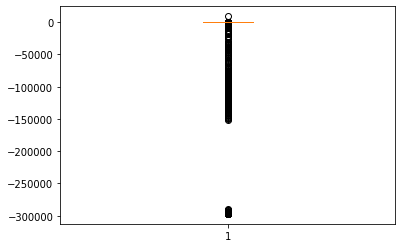

In [5]:
print(df['target'].describe().apply(lambda x:round(x,3)))
plt.boxplot(df['target'])

In [6]:
# IQR Filter
Q3 = df['target'].quantile(0.75)
Q1 = df['target'].quantile(0.25)
IQR = Q3 - Q1
C = (df['target']<Q1-1.5*IQR)|(df['target']>Q3+1.5*IQR)
out_idx = df.loc[C].index.tolist()
df = df.drop(out_idx)

count    145329.000000
mean          0.909587
std           0.022872
min           0.780661
25%           0.899436
50%           0.907753
75%           0.916843
max           1.103471
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ca7e2a780>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ca7e2ae80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ca7e2a630>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ca7e35550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ca7e35898>],
 'means': []}

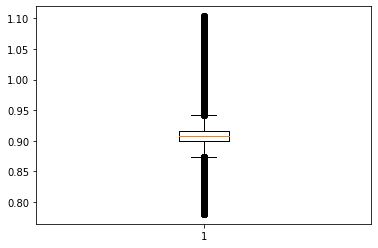

In [7]:
print(df['target'].describe())
plt.boxplot(df['target'])

In [8]:
# Quantile Filter
ub = df['target'].quantile(0.95)
lb = df['target'].quantile(0.05)
C = (df['target']<lb)|(df['target']>ub)
out_idx = df.loc[C].index.tolist()
df = df.drop(out_idx)

count    130795.000000
mean          0.908267
std           0.011037
min           0.883682
25%           0.900317
50%           0.907753
75%           0.915653
max           0.937730
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ca7ea0518>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ca7ea0ba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ca7ea0208>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ca7eaf278>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ca7eaf5c0>],
 'means': []}

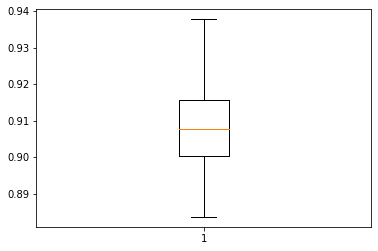

In [9]:
print(df['target'].describe())
plt.boxplot(df['target'])

# corr

In [10]:
df.iloc[:,10:20].corr().style.background_gradient()

,MLPAP_TI-0706B12,MLPAP_TI-0706B13,MLPAP_TI-0706B14,MLPAP_TI-0706B15,MLPAP_TI-0706B16,MLPAP_TI-0706B17,MLPAP_TI-0706B18,MLPAP_TI-0706B19,MLPAP_TI-0706B20,MLPAP_TI-0706B21
MLPAP_TI-0706B12,1,0.952041,0.959396,0.599202,0.933926,0.879586,0.786207,0.710883,0.620691,0.149172
MLPAP_TI-0706B13,0.952041,1,0.996538,0.634226,0.9934,0.977961,0.928643,0.875299,0.805457,0.2167
MLPAP_TI-0706B14,0.959396,0.996538,1,0.656769,0.995224,0.972508,0.914124,0.85482,0.778404,0.215149
MLPAP_TI-0706B15,0.599202,0.634226,0.656769,1,0.665662,0.649415,0.613027,0.597849,0.556702,0.223682
MLPAP_TI-0706B16,0.933926,0.9934,0.995224,0.665662,1,0.988328,0.943373,0.892209,0.823086,0.237683
MLPAP_TI-0706B17,0.879586,0.977961,0.972508,0.649415,0.988328,1,0.98193,0.947935,0.895614,0.261639
MLPAP_TI-0706B18,0.786207,0.928643,0.914124,0.613027,0.943373,0.98193,1,0.988577,0.959624,0.282403
MLPAP_TI-0706B19,0.710883,0.875299,0.85482,0.597849,0.892209,0.947935,0.988577,1,0.988944,0.294556
MLPAP_TI-0706B20,0.620691,0.805457,0.778404,0.556702,0.823086,0.895614,0.959624,0.988944,1,0.297766
MLPAP_TI-0706B21,0.149172,0.2167,0.215149,0.223682,0.237683,0.261639,0.282403,0.294556,0.297766,1


# 處裡共線性

In [11]:
corrs = abs(df.corr())
threshold = 0.95
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  48


In [12]:
# do remove
df = df.drop(cols_to_remove,axis=1)

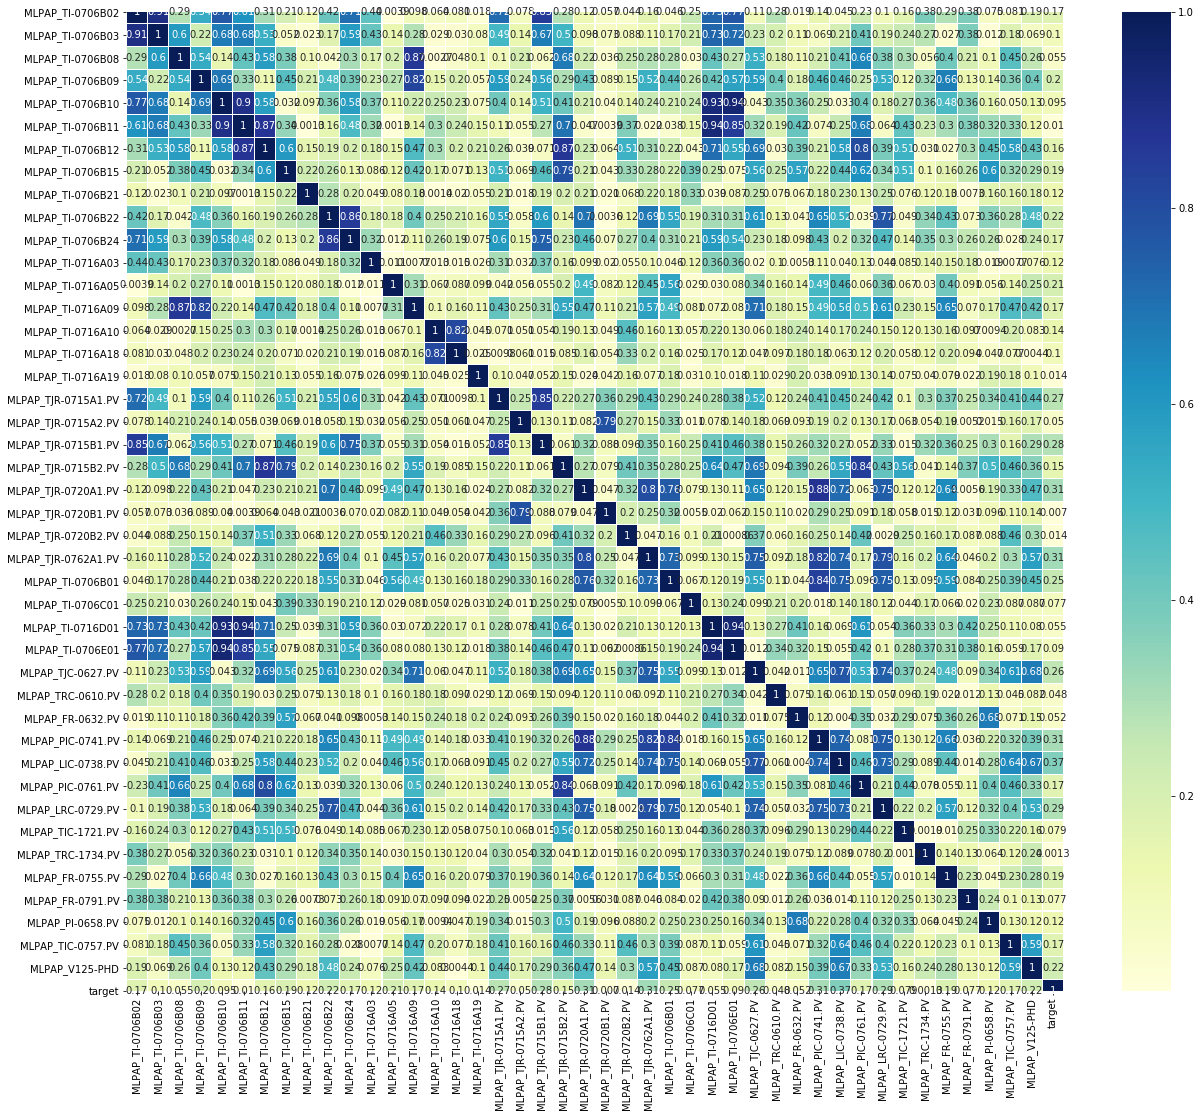

In [13]:
# after remove check corr
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

# Recursive Feature Elimination

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe = RFE(estimator = LinearRegression(),n_features_to_select = 31)

X = df
y = df['target']

new_X = rfe.fit_transform(X,y)
new_X = pd.DataFrame(new_X,index = X.index,columns = X.columns[rfe.get_support()])
new_X.head()

,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,MLPAP_TI-0706B12,MLPAP_TI-0706B22,MLPAP_TI-0706B24,MLPAP_TI-0716A09,...,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_FR-0791.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,421.996112,424.995929,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.004498,403.000684,...,34.707643,49.114940,34.926437,62.161964,181.607147,4.215451,13.177441,0.056350,0.054001,0.914110
2016-05-10 08:20:00,421.996112,425.041541,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.100484,403.000684,...,35.980597,49.137430,35.494560,62.267876,181.084756,4.236381,13.231014,0.084738,0.054001,0.919733
2016-05-10 08:30:00,421.996112,425.109958,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.004498,403.000684,...,33.797872,49.135555,34.616724,62.465860,177.599662,4.227079,13.221490,0.091835,0.054001,0.926436
2016-05-10 15:40:00,421.715731,427.687003,399.252972,395.446261,392.002989,389.622951,388.497742,390.200259,390.052790,403.578089,...,33.567251,49.169289,35.013840,62.394249,178.771310,4.248009,15.014401,0.496363,0.054001,0.887063
2016-05-10 23:40:00,421.003993,428.097506,397.996033,393.996100,390.654621,388.002611,387.000171,388.999261,388.197068,403.000684,...,35.167069,49.143052,34.719328,62.322638,182.122076,4.245102,15.637040,0.208935,0.054001,0.906869


In [15]:
df = new_X

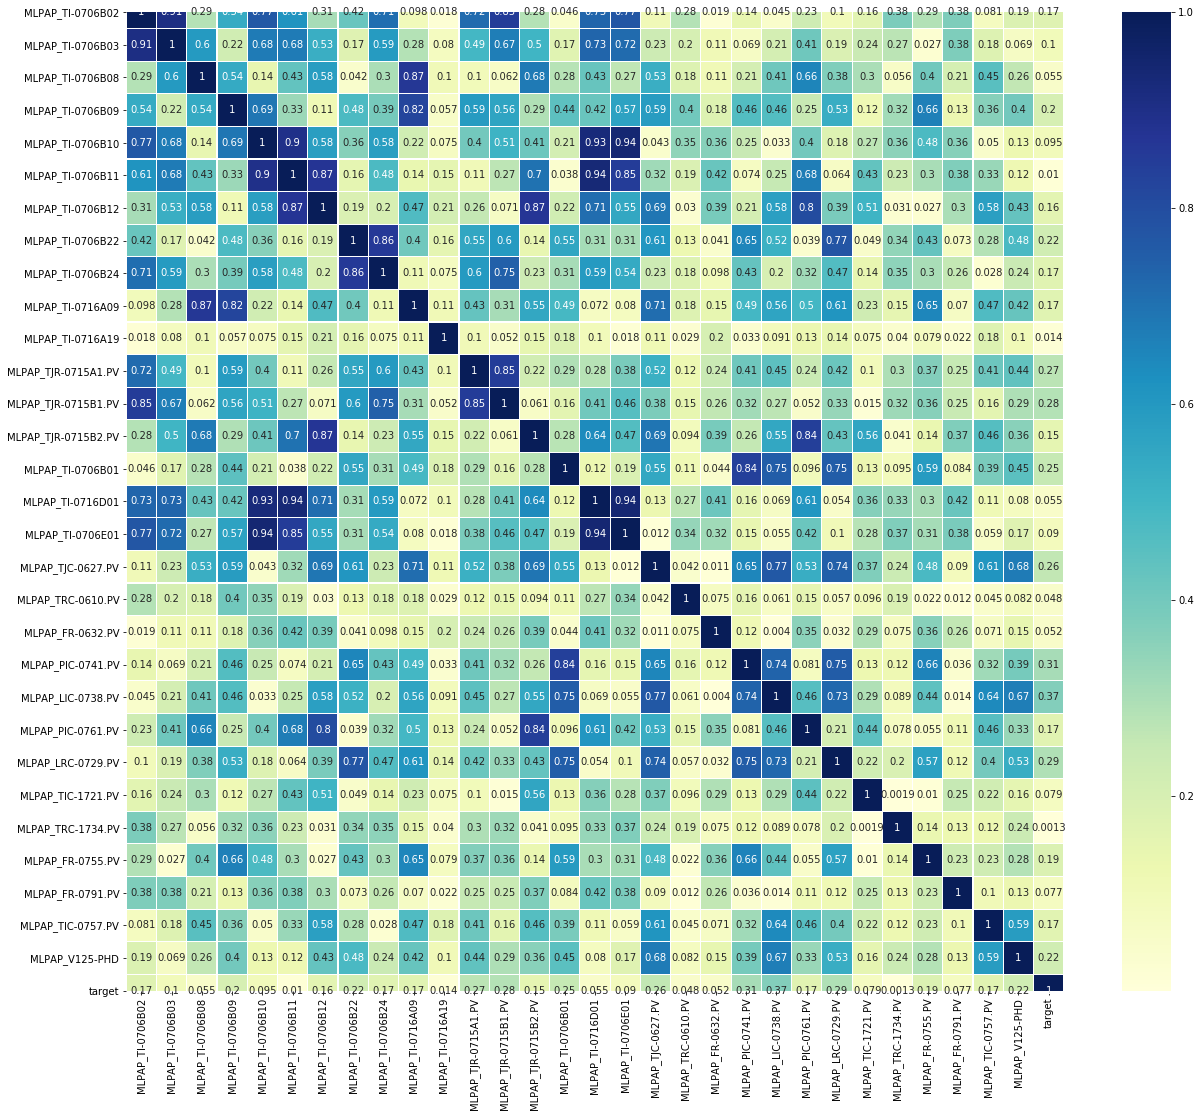

In [16]:
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

In [17]:
print(df.shape)
df.head()

(130795, 31)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,MLPAP_TI-0706B12,MLPAP_TI-0706B22,MLPAP_TI-0706B24,MLPAP_TI-0716A09,...,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_FR-0791.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,421.996112,424.995929,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.004498,403.000684,...,34.707643,49.114940,34.926437,62.161964,181.607147,4.215451,13.177441,0.056350,0.054001,0.914110
2016-05-10 08:20:00,421.996112,425.041541,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.100484,403.000684,...,35.980597,49.137430,35.494560,62.267876,181.084756,4.236381,13.231014,0.084738,0.054001,0.919733
2016-05-10 08:30:00,421.996112,425.109958,398.999278,397.000005,394.002688,391.997199,391.004787,392.001755,392.004498,403.000684,...,33.797872,49.135555,34.616724,62.465860,177.599662,4.227079,13.221490,0.091835,0.054001,0.926436
2016-05-10 15:40:00,421.715731,427.687003,399.252972,395.446261,392.002989,389.622951,388.497742,390.200259,390.052790,403.578089,...,33.567251,49.169289,35.013840,62.394249,178.771310,4.248009,15.014401,0.496363,0.054001,0.887063
2016-05-10 23:40:00,421.003993,428.097506,397.996033,393.996100,390.654621,388.002611,387.000171,388.999261,388.197068,403.000684,...,35.167069,49.143052,34.719328,62.322638,182.122076,4.245102,15.637040,0.208935,0.054001,0.906869


# save

In [18]:
df.to_csv('./train_FeatureSelected.csv')